# Import modules + define routines & EPICS channels

In [158]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [159]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        Data_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        
        DataT_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        DataT_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]
        
        Energy = BS_file[channel_energy][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        #Energy = BS_file[channel_waveplate][:][reprate_FEL]
        #Position = BS_file[channel_laser_pitch][:][reprate_FEL]
        #Palm = BS_file[channel_palm_analysis][:][reprate_FEL]
        
    return Data_pumped, Data_unpumped, Izero_pump, Izero_unpump, Energy, Position, DataT_pumped, DataT_unpumped#, Palm

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

def biexp(x, baseline, amplitude, t0, width, a1, t1, a2, t2):
    return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1)+a2*np.exp(-x/t2))

In [160]:
# only through raw and JF

channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_waveplate= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

#Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
channel_position = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator
channel_laser_yaw= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
channel_laser_pitch= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"
channel_palm_analysis= "data/SAROP11-PALMK118:ANALYSIS_PALM_DEL/data"     # Palm analysis probably fs ????


# Scan name

In [411]:
scan_name ="CytC_Fe2_monoscan_complete_003"

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

# Load one step and filter some data from I0

In [412]:
f= scan_name + "_step0001.BSREAD.h5"

filename = DIR + f

#(signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
#         signalT_pump_loop,signalT_unpump_loop, palm_loop) = LoadData_knife_edge(filename)
#no PALM
(signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
         signalT_pump_loop,signalT_unpump_loop) = LoadData_knife_edge(filename)

sigma_min=1.35
sigma_max=3.0

Izero_pump_original = Izero_pump_loop.copy()
signal_pump_original = signal_pump_loop.copy() 
#Izero_pump_loop = [x for x in Izero_pump_loop if (np.abs(x) > 1000)]
print (np.median(Izero_pump_loop)-sigma_min*(np.std(Izero_pump_loop)))
conditionPumpMax = Izero_pump_loop < np.median(Izero_pump_loop)+sigma_max*(np.std(Izero_pump_loop))
conditionPumpMin = Izero_pump_loop > np.median(Izero_pump_loop)-sigma_min*(np.std(Izero_pump_loop))

conditionUnPumpMax = Izero_unpump_loop < np.median(Izero_unpump_loop)+sigma_max*(np.std(Izero_unpump_loop))
conditionUnPumpMin = Izero_unpump_loop > np.median(Izero_unpump_loop)-sigma_min*(np.std(Izero_unpump_loop))

conditionGeneral = Izero_pump_loop > 1000
conditionGeneral2 = Izero_unpump_loop > 1000

Izero_pump_loop = Izero_pump_loop[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]
signal_pump_loop = signal_pump_loop[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]
#Izero_pump_loop = [x for x in Izero_unpump_loop if (np.abs(x) > 1000)]

Izero_pump_loop = np.asarray(Izero_pump_loop)
Izero_pump_original = np.asarray(Izero_pump_original)

-579.7295132453133


<IPython.core.display.Javascript object>


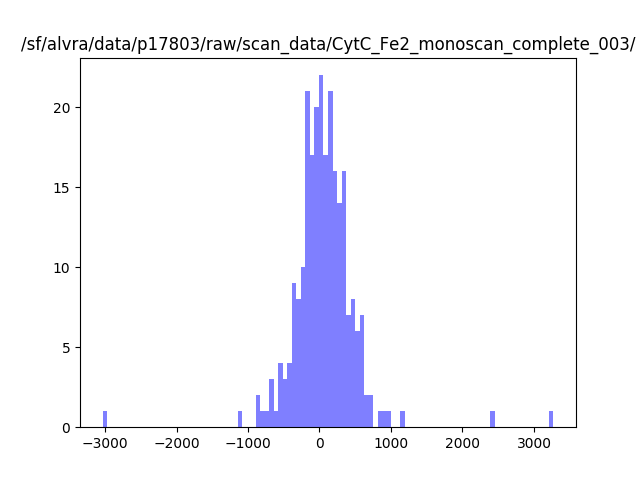

250 0


In [413]:
num_bins = 100
plt.figure()
plt.hist(Izero_pump_original, num_bins, facecolor='blue', alpha=0.5)
plt.hist(Izero_pump_loop, num_bins, facecolor='blue', alpha=0.5)
plt.title(DIR)

print (Izero_pump_original.size,Izero_pump_loop.size )

plt.show()

<IPython.core.display.Javascript object>


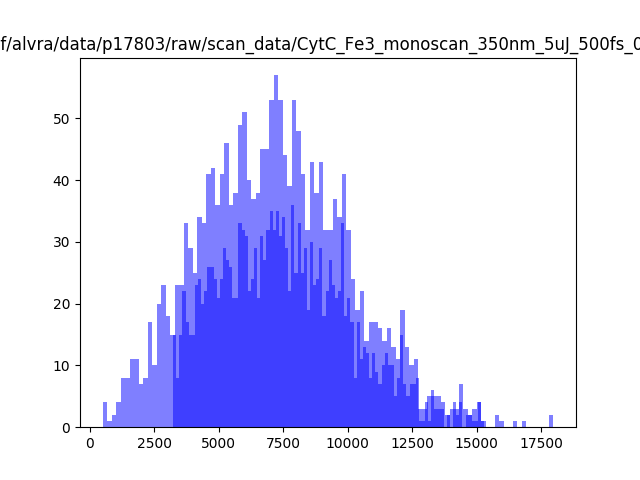

In [189]:
num_bins = 100
plt.figure()
plt.hist(Izero_pump_loop, num_bins, facecolor='blue', alpha=0.5)
plt.hist(Izero_pump_original, num_bins, facecolor='blue', alpha=0.5)
plt.title(DIR)


plt.show()

0 250


<IPython.core.display.Javascript object>


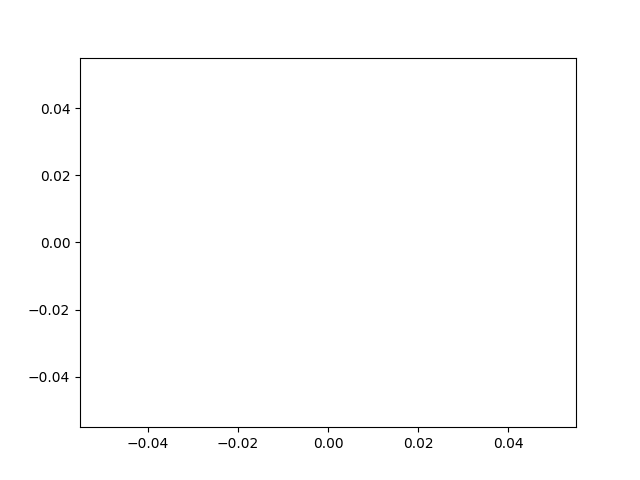

In [414]:
print (Izero_pump_loop.size, Izero_pump_original.size)
plt.figure()

#plt.plot(Izero_pump_original, label="original",marker='.')
plt.plot(Izero_pump_loop, label="Izero_pump",marker='.')

# Analyse full run

In [415]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 102G
-rw-r--r--.   1 root p17803 4.4G Jan 22 18:28 CytC_Fe2_monoscan_complete_003_step0000.JF02T09V01.h5
-rw-r--r--.   1 root p17803 1.8M Jan 22 18:29 CytC_Fe2_monoscan_complete_003_step0000.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 4.4G Jan 22 18:29 CytC_Fe2_monoscan_complete_003_step0001.JF02T09V01.h5
-rw-r--r--.   1 root p17803 1.7M Jan 22 18:29 CytC_Fe2_monoscan_complete_003_step0001.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 4.4G Jan 22 18:29 CytC_Fe2_monoscan_complete_003_step0002.JF02T09V01.h5
-rw-r--r--.   1 root p17803 207M Jan 22 18:30 CytC_Fe2_monoscan_complete_003_step0000.BSREAD.h5
-rw-r--r--.   1 root p17803 4.4G Jan 22 18:30 CytC_Fe2_monoscan_complete_003_step0003.JF02T09V01.h5
-rw-r--r--.   1 root p17803 1.8M Jan 22 18:30 CytC_Fe2_monoscan_complete_003_step0002.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 207M Jan 22 18:30 CytC_Fe2_monoscan_complete_003_step0001.BSREAD.h5
-rw-r--r--.   1 root p17803 1.7M Jan 22 18:30 CytC_Fe2_monoscan_complete_003_step0003.BSREAD_CA.h5
-

In [416]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_pump = []
Signal_unpump = []
Signal_diff = []
err_signal_pump = []
err_signal_unpump = []
err_signal_diff = []

#SignalT_pump = []
#SignalT_unpump = []
#err_signalT_pump = []

#Izero_pump = []
#Izero_unpump = []
#err_Izero = []
#Izero_loop = []

Position_mm = []
Energy_eV = []

Palm_fs = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=5:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        
        #(signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
        # signalT_pump_loop,signalT_unpump_loop, palm_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        #no palm
        (signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
         signalT_pump_loop,signalT_unpump_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        
        
        threshold_pump = Izero_pump_loop > 1000
        threshold_unpump = Izero_unpump_loop > 1000 
        condition_pumpMin = Izero_pump_loop > (np.median(Izero_pump_loop) - sigma_min*(np.std(Izero_pump_loop)))
        condition_pumpMax = Izero_pump_loop < (np.median(Izero_pump_loop) + sigma_max*(np.std(Izero_pump_loop)))
        
        condition_unpumpMin = Izero_unpump_loop > (np.median(Izero_unpump_loop) - sigma_min*(np.std(Izero_unpump_loop)))
        condition_unpumpMax = Izero_unpump_loop < (np.median(Izero_unpump_loop) + sigma_max*(np.std(Izero_unpump_loop)))

        signal_pump_loop = signal_pump_loop[condition_pumpMin & condition_pumpMax & condition_unpumpMin & \
         condition_unpumpMax & threshold_pump & threshold_unpump]
        Izero_pump_loop = Izero_pump_loop[condition_pumpMin & condition_pumpMax & condition_unpumpMin & \
         condition_unpumpMax & threshold_pump & threshold_unpump]
        
        signal_unpump_loop = signal_unpump_loop[condition_pumpMin & condition_pumpMax & condition_unpumpMin & \
         condition_unpumpMax & threshold_pump & threshold_unpump]
        Izero_unpump_loop = Izero_unpump_loop[condition_pumpMin & condition_pumpMax & condition_unpumpMin & \
         condition_unpumpMax & threshold_pump & threshold_unpump]
        
        signal_pump_loop_norm = signal_pump_loop / Izero_pump_loop
        signal_unpump_loop_norm = signal_unpump_loop / Izero_unpump_loop
        signal_diff_loop = signal_pump_loop_norm - signal_unpump_loop_norm
        
        Signal_pump.append(signal_pump_loop_norm.mean())
        Signal_unpump.append(signal_unpump_loop_norm.mean())
        Signal_diff.append(signal_diff_loop.mean())
        
        err_signal_pump.append(signal_pump_loop_norm.std()/np.sqrt(signal_pump_loop_norm.size))
        err_signal_unpump.append(signal_unpump_loop_norm.std()/np.sqrt(signal_unpump_loop_norm.size))
        err_signal_diff.append(signal_diff_loop.std()/np.sqrt(signal_diff_loop.size))
        
        #SignalT_pump.append(np.mean(signalT_pump_loop))
        #SignalT_unpump.append(signalT_unpump_loop.mean())
        #err_signalT_pump.append(signalT_pump_loop.std()/np.sqrt(signalT_pump_loop.size))
        
        energy_loop = [x for x in energy_loop if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_loop))
        Position_mm.append(np.mean(position_loop))
       # Palm_fs.append(np.mean(palm_loop))
        
        print (signal_pump_loop.size,signal_unpump_loop.size,np.mean(position_loop))
    
Signal_pump = np.asarray(Signal_pump)
Signal_unpump = np.asarray(Signal_unpump)
Signal_diff = np.asarray(Signal_diff)

err_signal_pump = np.asarray(err_signal_pump)
err_signal_unpump = np.asarray(err_signal_unpump)
err_signal_diff = np.asarray(err_signal_diff)


Energy_eV = np.asarray(Energy_eV)
Position_mm = np.asarray(Position_mm)
Palm_fs =np.asarray(Palm_fs)


print ("Job done!")

/sf/alvra/data/p17803/res/scan_info/CytC_Fe2_monoscan_complete_003_scan_info.json
Processing 21 files
step 1 of 21 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_003/CytC_Fe2_monoscan_complete_003_step0000.BSREAD.h5


/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:62: RuntimeWarning: Mean of empty slice.
/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:63: RuntimeWarning: Mean of empty slice.
/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:64: RuntimeWarning: Mean of empty slice.
/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered

0 0 150.7839978281472
step 2 of 21 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_003/CytC_Fe2_monoscan_complete_003_step0001.BSREAD.h5
0 0 150.78400182789122
step 3 of 21 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_003/CytC_Fe2_monoscan_complete_003_step0002.BSREAD.h5
0 0 150.7840014279168
step 4 of 21 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_003/CytC_Fe2_monoscan_complete_003_step0003.BSREAD.h5
0 0 150.78399822812162
step 5 of 21 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_003/CytC_Fe2_monoscan_complete_003_step0004.BSREAD.h5
0 0 150.7839962282496
step 6 of 21 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_003/CytC_Fe2_monoscan_complete_003_step0005.BSREAD.h5
0 0 150.7840050276864
step 7 of 21 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_003/CytC_Fe2_monoscan_complete_003_step0006.BSREAD.h5
0 0 150.

nan
(0,)


/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


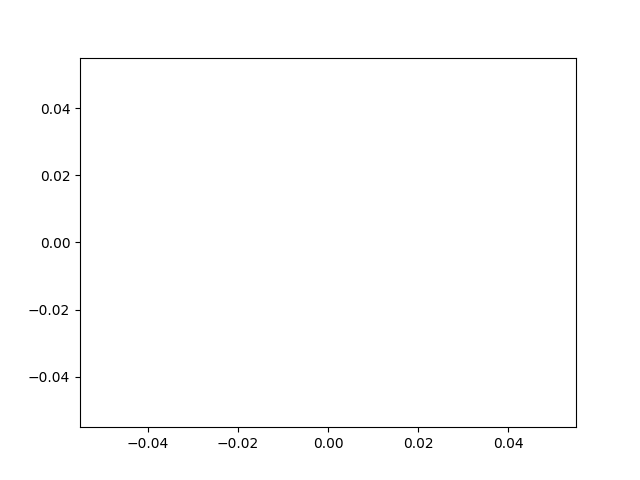

nan


/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Mean of empty slice.


In [417]:
print (signal_pump_loop.mean())
print (signal_unpump_loop.shape)
plt.figure()

plt.plot(Izero_pump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop-Izero_pump_loop, label="FEL+Laser",marker='.')

print (Izero_pump_loop.mean()- Izero_unpump_loop.mean())

In [418]:
low_err_pump= Signal_pump - err_signal_pump
high_err_pump= Signal_pump + err_signal_pump
low_err_unpump= Signal_unpump - err_signal_unpump
high_err_unpump= Signal_unpump + err_signal_unpump

low_err_diff= Signal_diff - err_signal_diff
high_err_diff= Signal_diff + err_signal_diff

# Plot Energy Scans

<IPython.core.display.Javascript object>


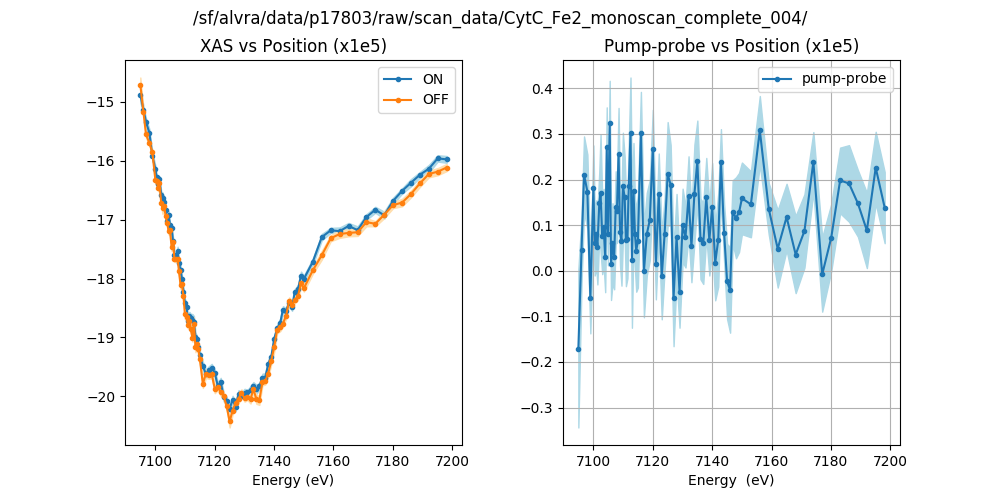

<IPython.core.display.Javascript object>


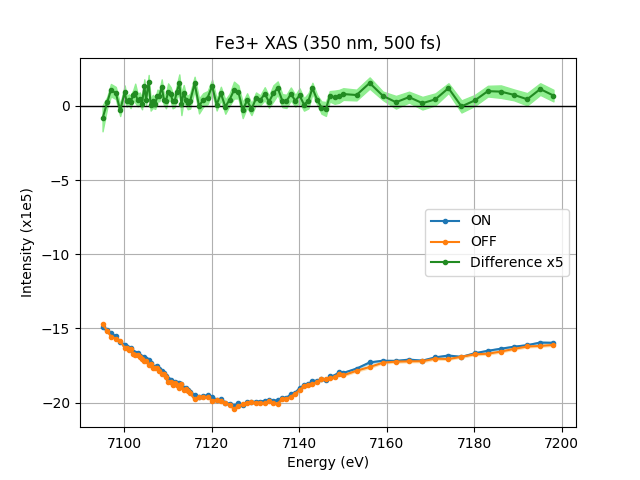

In [410]:
#change this values for plotting on sane axis!!
scale=1e5
offset= 0
magnification=5
baseline=0

#if a linear fit of the baseline is needed
#correction_1=(0.02976*(Energy_eV[0:40])-203.81)
#correction=correction_1
#correction_2=np.ones(len(Energy_eV))*baseline
#correction_2[0:40]=correction_1

# print(len(correction_2))
# print(correction_2)

#If it's not needed, uncomment this
correction_2=np.ones(len(Energy_eV))*baseline


#To plot Fluence scan
# Energy_eV=(1,2,3,4)
# print("the average pp signal is")
# print(np.mean(scale*Signal_diff+offset))
# print(np.std(scale*Signal_diff+offset))
# print(np.mean(scale*Signal_diff[1:3]+offset))
# print(np.std(scale*Signal_diff[1:3]+offset))


plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)

plt.subplot(1,2,1)
plt.plot(Energy_eV, scale*Signal_pump-correction_2, label="ON",marker='.')
plt.plot(Energy_eV, scale*Signal_unpump-correction_2, label="OFF",marker='.')
plt.fill_between(Energy_eV, scale*low_err_pump-correction_2, scale*high_err_pump-correction_2, color='lightblue')
plt.fill_between(Energy_eV, scale*low_err_unpump-correction_2, scale*high_err_unpump-correction_2, color='navajowhite')
plt.xlabel("Energy (eV)")
plt.gca().set_title('XAS vs Position (x1e5)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Energy_eV, scale*(Signal_diff)+offset/magnification, label="pump-probe",marker='.')
plt.fill_between(Energy_eV, scale*low_err_diff+offset/magnification, scale*high_err_diff+offset/magnification, color='lightblue')
plt.grid()
plt.xlabel("Energy  (eV)")
plt.gca().set_title('Pump-probe vs Position (x1e5)')
plt.legend(loc="best")
#plt.plot(Position_mm, [-0.00000005]*len(Energy_eV) , label="OFF")

#plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 


plt.show()
plt.figure()
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.plot(Energy_eV, (scale*Signal_pump-correction_2), label="ON",marker='.')
plt.plot(Energy_eV, (scale*Signal_unpump-correction_2), label="OFF",marker='.')
plt.fill_between(Energy_eV, (scale*low_err_pump-correction_2), (scale*high_err_pump-correction_2), color='lightblue')
plt.fill_between(Energy_eV, (scale*low_err_unpump-correction_2), (scale*high_err_unpump-correction_2), color='navajowhite')
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity (x1e5)")
plt.gca().set_title('Fe3+ XAS (350 nm, 500 fs)')
plt.legend(loc="best")
plt.plot(Energy_eV, magnification*scale*(Signal_pump-Signal_unpump)+offset, label="Difference x5", color='forestgreen',marker='.')
plt.fill_between(Energy_eV, magnification*scale*low_err_diff+offset, magnification*scale*high_err_diff+offset, color='lightgreen')
#plt.legend(loc='upper left')
plt.legend(loc='best')

plt.grid()


#plt.savefig('Fe2+ XAS (288 nm, 500 fs)')



# Saves XAS .h5 file

In [401]:
saveDir = "/das/work/p17/p17803/alvra_beamline_scripts/data_extract/"    # dest folder (needs to exist)
fn = str(saveDir + scan_name + "_processed_XAS.h5")
hf.close()

hf = h5py.File(fn, 'w')
hf.create_dataset('Energy_eV', data=Energy_eV)
hf.create_dataset('Signal_pump', data=Signal_pump)
hf.create_dataset('err_signal_pump', data=err_signal_pump)
hf.create_dataset('Signal_unpump', data=Signal_unpump)
hf.create_dataset('err_signal_unpump', data=err_signal_unpump)
hf.create_dataset('Signal_diff', data=Signal_diff)
hf.create_dataset('err_signal_diff', data=err_signal_diff)
hf.close()



# Plot Time Scans

<IPython.core.display.Javascript object>


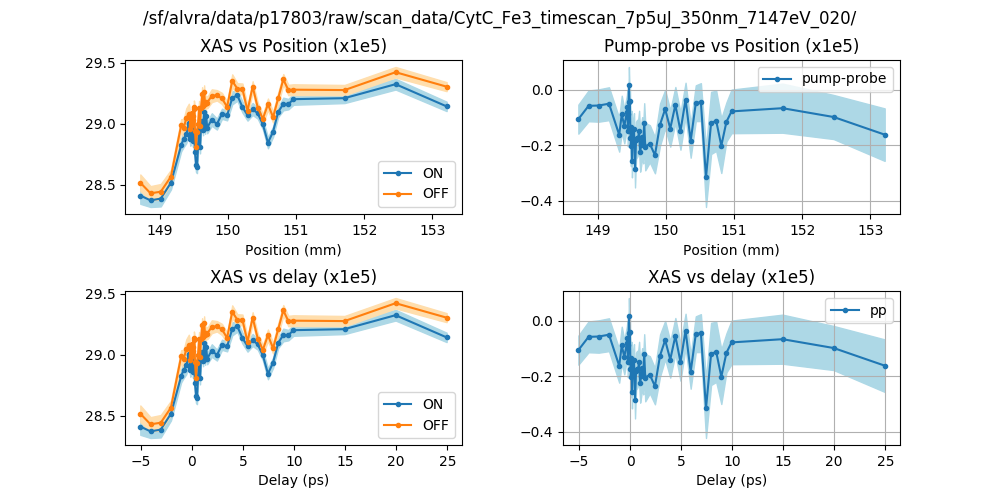

<IPython.core.display.Javascript object>


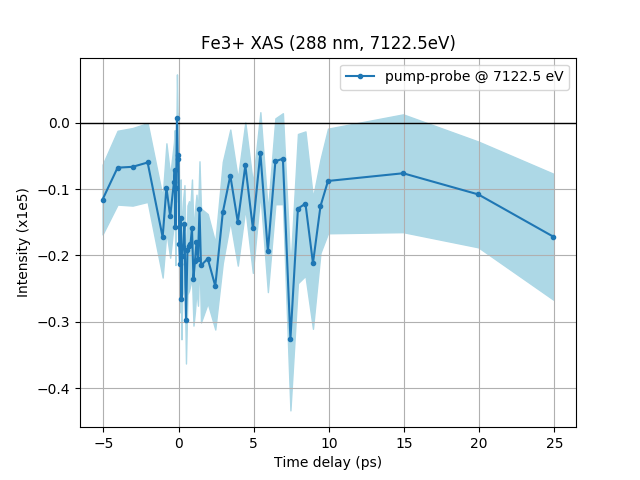

In [388]:
# change to right t0 !

Position_mm_un=Position_mm
arr1inds = Position_mm_un.argsort()
Position_mm = Position_mm_un[arr1inds[::-1]]
Signal_pump = Signal_pump[arr1inds[::-1]]
Signal_unpump = Signal_unpump[arr1inds[::-1]]
low_err_pump = low_err_pump[arr1inds[::-1]]
high_err_pump = high_err_pump[arr1inds[::-1]]
Signal_diff = Signal_diff[arr1inds[::-1]]
high_err_diff = high_err_diff[arr1inds[::-1]]
low_err_diff = low_err_diff[arr1inds[::-1]]
err_signal_diff = err_signal_diff[arr1inds[::-1]]


tzero=149.47
Delay_ps = (Position_mm - tzero)*2/(3e8*1e3*1e-12) # change to right t0 !

plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1e5

plt.subplot(2,2,1)
plt.plot(Position_mm, scale*Signal_pump, label="ON",marker='.')
plt.plot(Position_mm, scale*Signal_unpump, label="OFF",marker='.')
plt.fill_between(Position_mm, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Position_mm, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Position (mm)")
plt.gca().set_title('XAS vs Position (x1e5)')
plt.legend(loc="best")

plt.subplot(2,2,2)
plt.plot(Position_mm, scale*(Signal_diff), label="pump-probe",marker='.')
plt.fill_between(Position_mm, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Position (mm)")
plt.gca().set_title('Pump-probe vs Position (x1e5)')
plt.legend(loc="best")
#plt.plot(Position_mm, [-0.00000005]*len(Energy_eV) , label="OFF")

plt.subplot(2,2,3)
plt.plot(Delay_ps, scale*Signal_pump, label="ON",marker='.')
plt.plot(Delay_ps, scale*Signal_unpump, label="OFF",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Delay_ps, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay (x1e5)')
plt.legend(loc="best")

plt.subplot(2,2,4)
plt.plot(Delay_ps, scale*(Signal_diff), label="pp",marker='.')
plt.fill_between(Delay_ps, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay (x1e5)')


#plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 
plt.show()

#plt.savefig('Timescan_7_diode')

toffset=-0.01
plt.show()
plt.figure()
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.plot(Delay_ps, scale*(Signal_diff)+toffset, label="pump-probe @ 7122.5 eV",marker='.')
plt.fill_between(Delay_ps, scale*low_err_diff+toffset, scale*high_err_diff+toffset, color='lightblue')
plt.xlabel("Time delay (ps)")
plt.ylabel("Intensity (x1e5)")
plt.gca().set_title('Fe3+ XAS (288 nm, 7122.5eV)')
plt.legend(loc="best")
#plt.legend(loc='upper left')
plt.legend(loc='best')
plt.grid()


# Fitting

In [389]:
# Now fit with error funciton (defined above)
Signal_norm=scale*(Signal_diff)+toffset
yerr=((scale*high_err_diff+toffset)-(scale*low_err_diff+toffset))/2

#parameters,extras = curve_fit(errfunc, Position_mm, Signal_norm, p0 = [0, 0.1, 150.193, 0.05]) # [baseline, step amplitude, center, FWHM]
parameters,extras = curve_fit(biexp, Delay_ps, Signal_norm, p0 = [-0.05, 0.15, -0.0, 0.5, 1, 0.7, 0.5, 11],sigma=yerr) # [baseline, amplitude, t0, width, a1, t1, a2, t2]

print("Position t0 =",np.abs(np.round(parameters[2],3)),"ps")
print("Width =",np.abs(np.round(parameters[3],3)),"ps")

Position t0 = 0.08 ps
Width = 0.001 ps


/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


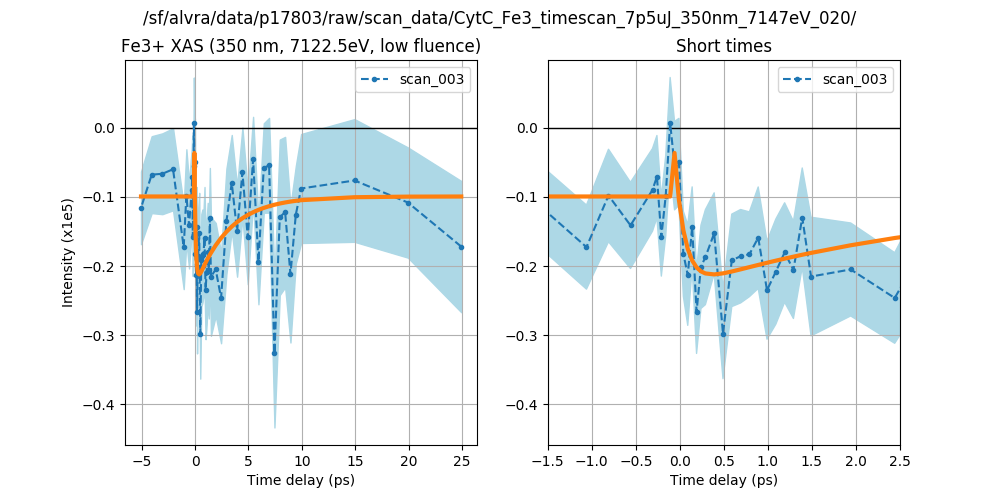

Position t0 = 0.08 ps
Width = 0.001 ps
a1 = 0.25
t1 = 0.113 ps
a2 = 0.284
t2 = 3.098 ps


In [390]:
#... and the plot with the fit curve


plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)

plt.subplot(1,2,1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.plot(Delay_ps, Signal_norm,'--',label="scan_003",marker='.')
#plt.errorbar(Delay_ps, Signal_norm,yerr, fmt='o',label="scan_003",marker='.')
plt.plot(Delay_ps, biexp(Delay_ps,*parameters),linewidth=3)
plt.fill_between(Delay_ps, scale*low_err_diff+toffset, scale*high_err_diff+toffset, color='lightblue')
plt.grid()
plt.xlabel("Time delay (ps)")
plt.ylabel("Intensity (x1e5)")
plt.gca().set_title('Fe3+ XAS (350 nm, 7122.5eV, low fluence)')
plt.legend(loc="best")
plt.show()

plt.subplot(1,2,2)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.plot(Delay_ps, Signal_norm,'--',label="scan_003",marker='.')
#plt.errorbar(Delay_ps, Signal_norm,yerr, fmt='o',label="scan_003",marker='.')
plt.plot(Delay_ps, biexp(Delay_ps,*parameters),linewidth=3)
plt.fill_between(Delay_ps, scale*low_err_diff+toffset, scale*high_err_diff+toffset, color='lightblue')
plt.grid()
plt.xlabel("Time delay (ps)")
plt.gca().set_title('Short times')
plt.legend(loc="best")
plt.show()
plt.xlim((-1.5,2.5))
plt.show()






print("Position t0 =",np.abs(np.round(parameters[2],3)),"ps")
print("Width =",np.abs(np.round(parameters[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters[4],3)))
print("t1 =",np.abs(np.round(parameters[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters[6],3)))
print("t2 =",np.abs(np.round(parameters[7],3)),"ps")


# Saves time scan .h5 file

In [391]:
saveDir = "/das/work/p17/p17803/alvra_beamline_scripts/data_extract/"    # dest folder (needs to exist)
fn = str(saveDir + scan_name + "_processed_TIM.h5")
hf.close()

hf = h5py.File(fn, 'w')
hf.create_dataset('Position_mm', data=Position_mm)
hf.create_dataset('Delay_ps', data=Delay_ps)

hf.create_dataset('t0', data=parameters[2])
hf.create_dataset('rise', data=parameters[3])
hf.create_dataset('a1', data=parameters[4])
hf.create_dataset('t1', data=parameters[5])
hf.create_dataset('a2', data=parameters[6])
hf.create_dataset('t2', data=parameters[7])
# 
hf.create_dataset('Signal_pump', data=Signal_pump)
hf.create_dataset('err_signal_pump', data=err_signal_pump)
hf.create_dataset('Signal_unpump', data=Signal_unpump)
hf.create_dataset('err_signal_unpump', data=err_signal_unpump)
hf.create_dataset('Signal_diff', data=Signal_diff)
hf.create_dataset('err_signal_diff', data=err_signal_diff)
hf.close()
#data_file = h5py.File(fn)
#h5py.File.close



# Saves variables in object for future use

In [ ]:
# save the pp sig and its xaxis into a variable name after the scan name. 
# This is convenient to compare different scans together, see cell below.
x = scan_name + "_DIFF"
t = scan_name + "_DELAY"
e = scan_name + "_eV"
o = scan_name + "_OFF"

vars()[x] = (Signal_diff)
vars()[t] = Delay_ps
vars()[e] = Energy_eV
vars()[o] = Signal_unpump

# Compare runs

In [ ]:
xaxis3=FeBpy_monoscan_350nm_10uJ_500fs_003_eV
xaxis9=FeBpy_monoscan_350nm_10uJ_500fs_009_eV

yaxis3=FeBpy_monoscan_350nm_10uJ_500fs_003_DIFF
yaxis4=FeBpy_monoscan_350nm_10uJ_100fs_004_DIFF
yaxis5=FeBpy_monoscan_350nm_10uJ_500fs_005_DIFF
yaxis7=FeBpy_monoscan_350nm_10uJ_500fs_007_DIFF
yaxis8=FeBpy_monoscan_350nm_10uJ_500fs_008_DIFF
yaxis9=FeBpy_monoscan_350nm_10uJ_500fs_009_DIFF



static=FeBpy_monoscan_350nm_10uJ_500fs_009_OFF

scale=1
plt.figure()
plt.plot(xaxis3, scale*yaxis3, label="pp",marker='.')
plt.plot(xaxis3, scale*yaxis4, label="pp",marker='.')
#plt.plot(xaxis3, scale*yaxis5, label="pp",marker='.')
plt.plot(xaxis3, scale*yaxis7, label="pp",marker='.')
plt.plot(xaxis3, scale*yaxis8, label="pp",marker='.')
plt.plot(xaxis9, scale*yaxis9, label="pp",marker='.')

# plt.plot(xaxis4, scale*yaxis4, label="pp",marker='.')
plt.grid()
plt.xlabel("Energy (eV)")
plt.gca().set_title('XAS Difference vs mono energy')
plt.show()

#y_mean=(yaxis3+yaxis4+yaxis5+yaxis7)/4
y_mean=(yaxis3+yaxis4+yaxis7+yaxis8+yaxis9)/5
plt.figure()
plt.plot(xaxis3, 10*y_mean, label="pp",marker='.')
plt.xlabel("Energy (eV)")
plt.gca().set_title('XAS Mean Difference vs mono energy')
plt.plot(Energy_eV, scale*static-0.00034, label="OFF",marker='.')
plt.show()


In [ ]:
# you have to run the analysis once and the data will be saved in variables scan_name_DELAY and scan_name_DIFF

xaxis1=CytC_Fe3_timescan_5uJ_288nm_7122eV_003_DELAY
yaxis1=CytC_Fe3_timescan_5uJ_288nm_7122eV_003_DIFF

xaxis2=CytC_Fe3_timescan_5uJ_288nm_7122eV_004_DELAY
yaxis2=CytC_Fe3_timescan_5uJ_288nm_7122eV_004_DIFF

xaxis3=CytC_Fe3_timescan_5uJ_288nm_7122eV_005_DELAY
yaxis3=CytC_Fe3_timescan_5uJ_288nm_7122eV_005_DIFF

xaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DELAY
yaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DIFF

xaxis2SORTED = sorted(xaxis2)
sortindices2=np.argsort(xaxis2)
yaxis2original=yaxis2
yaxis2=yaxis2[sortindices2]
#yaxisMODEL = biexp(x,-0.05, 0.1, 0, 0.5, 1, 2., 1, 10.)

plt.figure()
plt.plot(xaxis1, scale*yaxis1, label="pp",marker='.')
plt.plot(xaxis2, scale*yaxis2, label="pp",marker='.')
plt.plot(xaxis3, scale*yaxis3, label="pp",marker='.')
plt.plot(xaxis4, scale*yaxis4, label="pp",marker='.')
plt.grid()
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay (x1e5)')
plt.show()

In [ ]:
# Fit of the time traces
parameters1,extras = curve_fit(biexp, xaxis1, scale*yaxis1, p0 = [-0.05, 0.1, 0, 0.5, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
parameters2,extras = curve_fit(biexp, xaxis2, scale*yaxis2, p0 = [-0.05, 0.1, 0, 0.5, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
parameters3,extras = curve_fit(biexp, xaxis3, scale*yaxis3, p0 = [-0.0, 0.2, 0, 0.1, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]

print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_003")
print("Position t0 =",np.abs(np.round(parameters1[2],3)),"ps")
print("Width =",np.abs(np.round(parameters1[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters1[4],3)))
print("t1 =",np.abs(np.round(parameters1[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters1[6],3)))
print("t2 =",np.abs(np.round(parameters1[7],3)),"ps")

print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_004")
print("Position t0 =",np.abs(np.round(parameters2[2],3)),"ps")
print("Width =",np.abs(np.round(parameters2[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters2[4],3)))
print("t1 =",np.abs(np.round(parameters2[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters2[6],3)))
print("t2 =",np.abs(np.round(parameters2[7],3)),"ps")

print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_005")
print("Position t0 =",np.abs(np.round(parameters3[2],3)),"ps")
print("Width =",np.abs(np.round(parameters3[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters3[4],3)))
print("t1 =",np.abs(np.round(parameters3[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters3[6],3)))
print("t2 =",np.abs(np.round(parameters3[7],3)),"ps")

plt.figure()
plt.plot(xaxis3, scale*yaxis3, label="scan_005",marker='.')
plt.plot(xaxis3, biexp(xaxis3,parameters3[0],parameters3[1],parameters3[2],parameters3[3],parameters3[4],\
                       parameters3[5],parameters3[6],parameters3[7]))
plt.legend(loc="best")


plt.figure()
plt.subplot(4,1,1)
plt.plot(xaxis1, scale*yaxis1, label="scan_003",marker='.')
plt.plot(xaxis1, biexp(xaxis1,parameters1[0],parameters1[1],parameters1[2],parameters1[3],parameters1[4],\
                       parameters1[5],parameters1[6],parameters1[7]))
plt.legend(loc="best")

plt.subplot(4,1,2)
plt.plot(xaxis2, scale*yaxis2, label="scan_004",marker='.')
plt.plot(xaxis2, biexp(xaxis2,parameters2[0],parameters2[1],parameters2[2],parameters2[3],parameters2[4],\
                       parameters2[5],parameters2[6],parameters2[7]))

plt.subplot(4,1,3)
plt.plot(xaxis3, scale*yaxis3, label="scan_005",marker='.')
plt.plot(xaxis3, biexp(xaxis3,parameters3[0],parameters3[1],parameters3[2],parameters3[3],parameters3[4],\
                       parameters3[5],parameters3[6],parameters3[7]))
#plt.plot(xaxis1 - parameters1[2], biexp(xaxis1 - parameters1[2],parameters1[0],parameters1[1],\
#                 parameters1[2],parameters1[3],parameters1[4],parameters1[5],parameters1[6],parameters1[7]))
#plt.plot(xaxis2 - parameters2[2], biexp(xaxis2 - parameters2[2],parameters2[0],parameters2[1],parameters2[2],\
#                 parameters2[3],parameters2[4],parameters2[5],parameters2[6],parameters2[7]))

plt.subplot(4,1,4)
#plt.plot(xaxis4, scale*yaxis4, label="scan_006",marker='.')
#plt.plot(xaxis4, biexp(xaxis4,parameters4[0],parameters4[1],parameters4[2],parameters4[3],parameters4[4],\
#                       parameters4[5],parameters4[6],parameters4[7]))
plt.plot(xaxis1 - parameters1[2], yaxis1, label="scan_003",marker='.')
plt.plot(xaxis2 - parameters2[2], yaxis2, label="scan_004",marker='.')
plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.5,hspace = 0.3) 
plt.show()


# More stuff

In [ ]:
myList = np.concatenate((np.arange(7100,7105,1), np.arange(7105,7120,0.5), np.arange(7120,7160,1),np.arange(7160,7200,3)))

In [ ]:
time_zero = 150.188         #this is in mm from the delay scans

desidered_delays = [-10,-1,1]  
#choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")


T_1 = np.arange(149.4372,150.1872


mtime = np.concatenate((np.arange(149.4372,7105,1), np.arange(7105,7120,0.5), np.arange(7120,7160,1),np.arange(7160,7200,3)))

In [ ]:
print(time_zero)

In [ ]:
desidered_delays = [-10,-1,1]  


In [ ]:
Position_mm

delay_ps = (Position_mm - 150.188)*2/(3e8*1e3*1e-12)
print(delay_ps)

In [ ]:
t0_mm = 150.347
delaylist=np.concatenate((np.arange(-5.,-1.+1.,1.), np.arange(-0.25,0.3+0.05,0.05), \
                          np.arange(0.35,1.5+0.1,0.1),np.arange(2.,10.+0.5,0.5),[15.,20.,25.]))
position_list = delaylist*(3e8*1e3*1e-12)/2 + t0_mm
print(position_list)
print(delaylist)
len(delaylist)

In [ ]:
mytime = np.concatenate((np.arange(149.4372,150.188,0.15), np.arange(150.1505,150.2255,0.007), np.arange(150.2255,150.3382,0.015), np.arange(150.3382,151.6895,0.0
   ...: 75)))